In [1]:
import numpy as np
import torch
import yaml
from pyemittance.emittance_calc import EmitCalc
from pyemittance.load_json_configs import load_configs
from pyemittance.simulation import BeamSim
from emitopt.beam_dynamics import get_quad_strength_conversion_factor

In [2]:
CONFIG = load_configs('LCLS2_OTR0H04')
CONFIG['beamline_info']

{'name': 'LCLS2',
 'species': 'electron',
 'Lquad': 0.1244,
 'energy': 80000000.0,
 'Twiss0': [1e-06, 1e-06, 5.01, 5.01, 0.049, 0.049],
 'rMatx': [1, 2.2, 0, 1],
 'rMaty': [1, 2.2, 0, 1]}

In [3]:
BUNCH_PARAMS0 = {
    'total_charge': 50e-12,
    'norm_emit_x': 1e-6,
    'norm_emit_y': 2e-6,
    'beta_x': 10,
    'alpha_x': -1,
    'beta_y': 11,
    'alpha_y': -2,
    'energy': 80e6,
    'species':'electron'
}
sim = BeamSim(bunch_params=BUNCH_PARAMS0, beamline_info=CONFIG['beamline_info'])

# sim.screen_sigma('x'), sim.screen_sigma('y')
quad_vals = np.linspace(-3,3, 20)

meas =  np.array([sim.beam_size_meas(v) for v in quad_vals])
meas_x = meas[:,0]
meas_y = meas[:,1]

(9.999999999999997e-07,
 2.000000000000004e-06,
 10.0,
 11.000000000000005,
 -0.9999999999999999,
 -1.999999999999997)

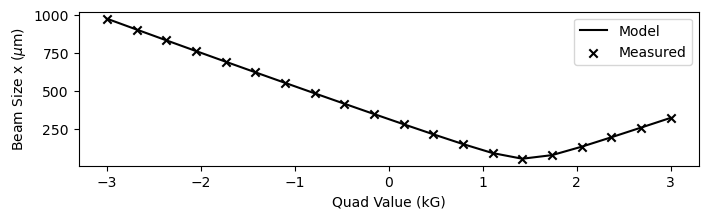

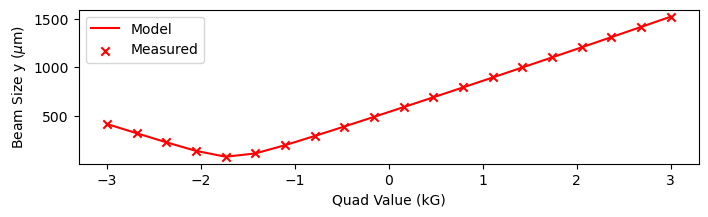

In [4]:
ef = EmitCalc({'x': quad_vals,'y': quad_vals},
              {'x': meas_x ,'y': meas_y},
              {'x': meas_x*0.03 ,'y': meas_y*0.03},
              config_dict=CONFIG,
             )

ef.plot = True         
ef.calc_bmag = True
result = ef.get_emit()

result['norm_emit_x'], result['norm_emit_y'], result['beta_x'], result['beta_y'], result['alpha_x'], result['alpha_y']

In [5]:
energy = CONFIG['beamline_info']['energy'] * 1e-9
q_len = CONFIG['beamline_info']['Lquad']
scale = get_quad_strength_conversion_factor(E=energy, q_len=q_len)
k = torch.tensor(scale*quad_vals)

In [6]:
test_emit_vals = {'k_x': k.tolist(),
                  'k_y': (-k).tolist(),
                 'xrms': meas_x.tolist(),
                 'yrms': meas_y.tolist(),
                  'rmat_x': [CONFIG['beamline_info']['rMatx'][0:2],
                             CONFIG['beamline_info']['rMatx'][2:4]],
                  'rmat_y': [CONFIG['beamline_info']['rMaty'][0:2],
                             CONFIG['beamline_info']['rMaty'][2:4]],
                  'q_len': CONFIG['beamline_info']['Lquad'],
                  'beta0_x': CONFIG['beamline_info']['Twiss0'][2],
                  'beta0_y': CONFIG['beamline_info']['Twiss0'][3],
                  'alpha0_x': CONFIG['beamline_info']['Twiss0'][4],
                  'alpha0_y': CONFIG['beamline_info']['Twiss0'][5],
                  'emit_x': float(result['emit_x']), 
                  'bmag_x': float(result['screen_bmagx']),
                  'emit_y': float(result['emit_y']),
                  'bmag_y': float(result['screen_bmagy']),
                 }
test_emit_units = {'k_x': 'm^-2',
                   'k_y': 'm^-2',
                 'xrms': 'm',
                 'yrms': 'm',
                  'rmat_x': [['none', 'm'],
                             ['m^-1', 'none']],
                  'rmat_y': [['none', 'm'],
                             ['m^-1', 'none']],
                  'q_len': 'm',
                  'beta0_x': 'm',
                  'beta0_y': 'm',
                  'alpha0_x': 'none',
                  'alpha0_y': 'none',
                  'emit_x': 'm*rad', 
                  'bmag_x': 'none',
                  'emit_y': 'm*rad',
                  'bmag_y': 'none',
                  }

test_emit_dict={'values': test_emit_vals,
               'units': test_emit_units}
print("The python dictionary is:")
print(test_emit_dict)
file=open("test_emit.yaml","w")
yaml.dump(test_emit_dict,file)
file.close()
print("YAML file saved.")

The python dictionary is:
{'values': {'k_x': [-9.013447540628858, -8.064663588983715, -7.115879637338572, -6.16709568569343, -5.218311734048287, -4.269527782403143, -3.320743830758001, -2.3719598791128584, -1.423175927467715, -0.47439197582257164, 0.47439197582257164, 1.4231759274677136, 2.371959879112857, 3.320743830757999, 4.269527782403142, 5.218311734048285, 6.167095685693429, 7.115879637338572, 8.064663588983715, 9.013447540628858], 'k_y': [9.013447540628858, 8.064663588983715, 7.115879637338572, 6.16709568569343, 5.218311734048287, 4.269527782403143, 3.320743830758001, 2.3719598791128584, 1.423175927467715, 0.47439197582257164, -0.47439197582257164, -1.4231759274677136, -2.371959879112857, -3.320743830757999, -4.269527782403142, -5.218311734048285, -6.167095685693429, -7.115879637338572, -8.064663588983715, -9.013447540628858], 'xrms': [0.0009751707007371648, 0.0009042365347600973, 0.0008336584312678214, 0.0007634414029303233, 0.0006935927136482315, 0.0006241230978843305, 0.00055